In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import glob
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [15]:
def attach_latlon(geo_ds, nav_ds):
    """
    Adds interpolated lat/lon coordinates to a geophysical dataset
    using navigation control points.
    """
    lat_ctl = nav_ds['latitude'].data
    lon_ctl = nav_ds['longitude'].data
    cols = nav_ds['cntl_pt_cols'].data  # pixel_control_points

    n_lines, n_pixels = geo_ds.dims['number_of_lines'], geo_ds.dims['pixels_per_line']

    lat_full = np.empty((n_lines, n_pixels), dtype=np.float32)
    lon_full = np.empty((n_lines, n_pixels), dtype=np.float32)

    for i in range(n_lines):
        f_lat = interp1d(cols, lat_ctl[i, :], bounds_error=False, fill_value="extrapolate")
        f_lon = interp1d(cols, lon_ctl[i, :], bounds_error=False, fill_value="extrapolate")
        lat_full[i, :] = f_lat(np.arange(n_pixels))
        lon_full[i, :] = f_lon(np.arange(n_pixels))

    geo_ds = geo_ds.assign_coords(
        lat=(('number_of_lines', 'pixels_per_line'), lat_full),
        lon=(('number_of_lines', 'pixels_per_line'), lon_full)
    )

    return geo_ds

def scatter_plot_var(ds, var_name, title=None, cmap='viridis', s=1):
    """
    Safe scatter plot of a geophysical variable using lat/lon.
    Only plots valid (finite) pixels. Adds coastlines and landfills.
    """
    var = ds[var_name]
    lat = ds['lat']
    lon = ds['lon']
    
    # Flatten everything
    lat_vals = lat.values.flatten()
    lon_vals = lon.values.flatten()
    data_vals = var.values.flatten()

    # Filter out NaNs
    mask = np.isfinite(lat_vals) & np.isfinite(lon_vals) & np.isfinite(data_vals)
    
    # Create a map with Cartopy
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()], crs=ccrs.PlateCarree())
    
    # Add coastlines and land features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    
    # Scatter plot
    sc = ax.scatter(lon_vals[mask], lat_vals[mask], c=data_vals[mask],
                     cmap=cmap, s=s, marker='.', alpha=0.8, transform=ccrs.PlateCarree())
    
    # Add colorbar and labels
    plt.colorbar(sc, label=var.attrs.get('long_name', var_name))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title or var_name)
    plt.tight_layout()
    plt.show()

# Main function to load files and plot
def load_and_plot(nc_files, var_name='chlor_a', cmap='viridis'):
    """
    Loads a dataset, attaches lat/lon, and plots a specified variable.
    """
    # Open the first file to read the data
    geo_ds = xr.open_dataset(nc_files[0], group='geophysical_data')
    nav_ds = xr.open_dataset(nc_files[0], group='navigation_data')

    # Add lat/lon coordinates
    geo_ds = attach_latlon(geo_ds, nav_ds)

    # Plot the variable (e.g., 'chlor_a')
    scatter_plot_var(geo_ds, var_name, title=f'{var_name} Concentration', cmap=cmap)

def load_l2_datasets(nc_files, var_name='chlor_a'):
    """
    Loads multiple L2 datasets, attaches lat/lon, and returns a list of datasets.
    Each dataset corresponds to one file and has lat/lon attached.
    """
    datasets = []

    for file in nc_files:
        try:
            geo_ds = xr.open_dataset(file, group='geophysical_data')
            nav_ds = xr.open_dataset(file, group='navigation_data')

            geo_ds = attach_latlon(geo_ds, nav_ds)

            # Only keep the variable of interest + lat/lon
            geo_ds = geo_ds[[var_name, 'lat', 'lon']]

            datasets.append(geo_ds)
        except Exception as e:
            print(f"Skipping {file} due to error: {e}")
    
    return datasets


def plot_multiple_l2_datasets(datasets, var_name='chlor_a', cmap='viridis', s=1):
    """
    Scatter plots data from multiple L2 datasets.
    """
    plt.figure(figsize=(12, 7))

    for ds in datasets:
        var = ds[var_name]
        lat = ds['lat']
        lon = ds['lon']

        lat_vals = lat.values.flatten()
        lon_vals = lon.values.flatten()
        data_vals = var.values.flatten()

        mask = np.isfinite(lat_vals) & np.isfinite(lon_vals) & np.isfinite(data_vals)

        plt.scatter(lon_vals[mask], lat_vals[mask], c=data_vals[mask],
                    cmap=cmap, s=s, marker='.', alpha=0.6)

    plt.colorbar(label=var.attrs.get('long_name', var_name))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f'{var_name} from {len(datasets)} L2 Files')
    plt.tight_layout()
    plt.show()

Found 41 NetCDF files.


C:\Users\Makai\AppData\Local\Temp\ipykernel_11780\1092997806.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_lines, n_pixels = geo_ds.dims['number_of_lines'], geo_ds.dims['pixels_per_line']
C:\Users\Makai\AppData\Local\Temp\ipykernel_11780\1092997806.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_lines, n_pixels = geo_ds.dims['number_of_lines'], geo_ds.dims['pixels_per_line']
C:\Users\Makai\AppData\Local\Temp\ipykernel_11780\1092997806.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more con

Skipping data\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210630T182501.L2.OC.nc due to error: "No variable named 'cntl_pt_cols'. Variables on the dataset include ['longitude', 'latitude', 'tilt']"
Skipping data\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210630T183001.L2.OC.nc due to error: "No variable named 'cntl_pt_cols'. Variables on the dataset include ['longitude', 'latitude', 'tilt']"
Skipping data\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210630T200501.L2.OC.nc due to error: "No variable named 'cntl_pt_cols'. Variables on the dataset include ['longitude', 'latitude', 'tilt']"
Skipping data\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210701T191000.L2.OC.nc due to error: "No variable named 'cntl_pt_cols'. Variables on the dataset include ['longitude', 'latitude', 'tilt']"
Skipping data\Mississippi_2021-06-21_2021-07-21\AQUA_MODIS.20210702T181501.L2.OC.nc due to error: "No variable named 'cntl_pt_cols'. Variables on the dataset include ['longitude', 'latitude', 'til

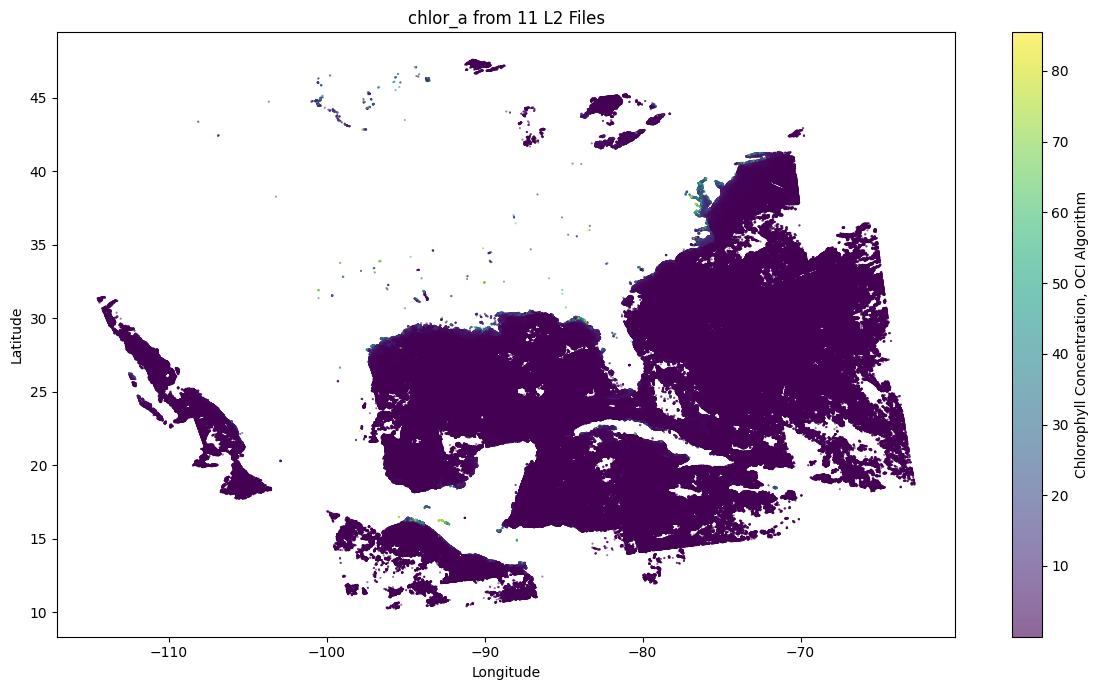

In [16]:
nc_files = glob.glob(os.path.join('data', '**', '*.nc'), recursive=True)
print(f"Found {len(nc_files)} NetCDF files.")

datasets = load_l2_datasets(nc_files, var_name='chlor_a')
plot_multiple_l2_datasets(datasets, var_name='chlor_a', cmap='viridis')